Imports

In [271]:
from modAL import batch, uncertainty, density, utils, disagreement
from modAL.models import ActiveLearner, Committee
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets, svm, metrics, tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics.pairwise import paired_distances
import numpy as np
from functools import partial
from typing import Union, Tuple
import pandas as pd
from art.attacks.evasion import FastGradientMethod, DeepFool
from art.estimators.classification.scikitlearn import SklearnClassifier
from copy import deepcopy
from importlib import reload
from tqdm.notebook  import tqdm, trange
from joblib import Parallel, delayed

# IMITATE
# Ideally would be in a subdirectory but not supported by ipynb, see importnb for a better replacement.
from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

Function Definitions

Misc

In [276]:
class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, desc=None, leave=True, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        self.desc = desc
        self.leave = leave
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total, leave=self.leave, desc=self.desc) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()


Core

In [280]:
def active_split(X, Y, test_size=0.5, labeled_size=0.1, shuffle=True):
    """
    Split data into three sets:
    * Labeled training set (0.1)
    * Unlabeled training set, to be queried (0.4)
    * Labeled test (0.5)
    """

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, shuffle=shuffle, random_state=42)
    X_labelled, X_unlabelled, Y_labelled, Y_oracle = train_test_split(X_train, Y_train, test_size=(1-labeled_size/test_size), shuffle=shuffle, random_state=42)

    return X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test

def active_learn(
    X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test, 
    query_strategy, model='svm-linear', teach_advesarial=False
) -> Tuple[list, list]:
    """
    Perform active learning on the given dataset using a linear SVM model, querying data with the given query strategy.

    Returns the accuracy curve.
    """

    if model == 'svm-linear':
        learner = ActiveLearner(
            estimator=svm.SVC(kernel='linear', probability=True), 
            X_training=X_labelled, 
            y_training=Y_labelled, 
            query_strategy=query_strategy
        )
    elif model == 'committee':
        learner = Committee(
            learner_list=[
                ActiveLearner(
                    estimator=svm.SVC(kernel='linear', probability=True), 
                    X_training=X_labelled, 
                    y_training=Y_labelled),
                # committee: logistic regression, svm-linear, svm-rbf, guassian process classifier
                ActiveLearner(
                    estimator=svm.SVC(kernel='rbf', probability=True), 
                    X_training=X_labelled, 
                    y_training=Y_labelled),
                ActiveLearner(
                    estimator=GaussianProcessClassifier(), 
                    X_training=X_labelled, 
                    y_training=Y_labelled),
                ActiveLearner(
                    estimator=LogisticRegression(), 
                    X_training=X_labelled, 
                    y_training=Y_labelled)
            ],
            query_strategy=disagreement.vote_entropy_sampling
        )
    else:
        raise Exception('unknown model')

    trained = [len(X_labelled)]
    accuracy = [accuracy_score(Y_test, learner.estimator.predict(X_test))]
    f1 = [f1_score(Y_test, learner.estimator.predict(X_test))]
    roc_auc = [roc_auc_score(Y_test, learner.estimator.decision_function(X_test))]
    
    while len(X_unlabelled) != 0:
        if query_strategy == fgm:
            query_idx, advesarial_examples = learner.query(X_unlabelled)
        
            learner.teach(X_unlabelled[query_idx], Y_oracle[query_idx])
            if teach_advesarial:
                learner.teach(advesarial_examples, Y_oracle[query_idx])
        else:
            query_idx, _ = learner.query(X_unlabelled)
            learner.teach(X_unlabelled[query_idx], Y_oracle[query_idx])

        X_unlabelled = np.delete(X_unlabelled, query_idx, axis=0)
        Y_oracle = np.delete(Y_oracle, query_idx, axis=0)

        trained.append(trained[-1]+len(query_idx))

        accuracy.append(accuracy_score(Y_test, learner.estimator.predict(X_test)))
        f1.append(f1_score(Y_test, learner.estimator.predict(X_test)))
        roc_auc.append(roc_auc_score(Y_test, learner.estimator.decision_function(X_test)))
    
    return (trained, accuracy, f1, roc_auc)

def active_learn2(
    X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test, 
    query_strategy, model='svm-linear', teach_advesarial=False
) -> Tuple[list, list]:
    """
    Perform active learning on the given dataset using a linear SVM model, querying data with the given query strategy.

    Returns the accuracy curve.
    """

    if model == 'svm-linear':
        learner = ActiveLearner(
            estimator=svm.SVC(kernel='linear', probability=True), 
            X_training=X_labelled, 
            y_training=Y_labelled, 
            query_strategy=query_strategy
        )
    elif model == 'committee':
        learner = Committee(
            learner_list=[
                ActiveLearner(
                    estimator=svm.SVC(kernel='linear', probability=True), 
                    X_training=X_labelled, 
                    y_training=Y_labelled),
                # committee: logistic regression, svm-linear, svm-rbf, guassian process classifier
                ActiveLearner(
                    estimator=svm.SVC(kernel='rbf', probability=True), 
                    X_training=X_labelled, 
                    y_training=Y_labelled),
                ActiveLearner(
                    estimator=GaussianProcessClassifier(), 
                    X_training=X_labelled, 
                    y_training=Y_labelled),
                ActiveLearner(
                    estimator=LogisticRegression(), 
                    X_training=X_labelled, 
                    y_training=Y_labelled)
            ],
            query_strategy=disagreement.vote_entropy_sampling
        )
    else:
        raise Exception('unknown model')

    metrics = Metrics()
    metrics.collect(len(X_labelled), learner.estimator, Y_test, X_test)
    
    while len(X_unlabelled) != 0:
        if query_strategy == fgm:
            query_idx, advesarial_examples = learner.query(X_unlabelled)
        
            learner.teach(X_unlabelled[query_idx], Y_oracle[query_idx])
            if teach_advesarial:
                learner.teach(advesarial_examples, Y_oracle[query_idx])
        else:
            query_idx, _ = learner.query(X_unlabelled)
            learner.teach(X_unlabelled[query_idx], Y_oracle[query_idx])

        X_unlabelled = np.delete(X_unlabelled, query_idx, axis=0)
        Y_oracle = np.delete(Y_oracle, query_idx, axis=0)

        metrics.collect(metrics.frame.x.iloc[-1]+len(query_idx), learner.estimator, Y_test, X_test)
    
    return metrics

def random_batch(
    classifier: sklearn.base.BaseEstimator, 
    X: Union[list, np.ndarray], 
    n_instances: int = 1, 
    random_tie_break: bool = False, 
    **uncertainty_measure_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng()
    try:
        idx = rng.choice(X.shape[0], n_instances, replace=False)
    except ValueError:
        idx = rng.choice(X.shape[0], X.shape[0], replace=False)
    return (idx, X[idx])

def uncertainty_id(clf, X, n_instances=1, **kwargs):
    """
    Sort by the minimum highest confidence labelling.
    """
    return np.argsort(uncertainty.classifier_uncertainty(clf, X) * density.information_density(X))[:n_instances]


def fgm(
    classifier: sklearn.base.BaseEstimator, 
    X: Union[list, np.ndarray], 
    n_instances: int = 1, 
    random_tie_break: bool = False, 
    **uncertainty_measure_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    classifier = SklearnClassifier(model=classifier.estimator)
    attack = FastGradientMethod(estimator=classifier, eps=0.2)

    adversarial_examples = attack.generate(X)

    # TODO: I have no idea if this is the right way to rank them, it seems to be right intuitively but...
    dists = paired_distances(X, adversarial_examples, metric='euclidean')

    idx = np.argsort(dists)

    # This is kind of a hack, modAL is not built to deal with passing extra information.
    result =  (idx[:n_instances], adversarial_examples[idx[:n_instances]])

    return result

def deepfool(
    classifier: sklearn.base.BaseEstimator, 
    X: Union[list, np.ndarray], 
    n_instances: int = 1, 
    random_tie_break: bool = False, 
    verbose: bool = False,
    **uncertainty_measure_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    classifier = SklearnClassifier(model=classifier.estimator)
    attack = DeepFool(classifier=classifier, verbose=verbose)

    adversarial_examples = attack.generate(X)

    # TODO: I have no idea if this is the right way to rank them, it seems to be right intuitively but...
    dists = paired_distances(X, adversarial_examples, metric='euclidean')

    idx = np.argsort(dists)

    # This is kind of a hack, modAL is not built to deal with passing extra information.
    result =  (idx[:n_instances], adversarial_examples[idx[:n_instances]])

    return result

Metrics

In [262]:
class Metrics:
    def __init__(self, name=None, metrics=None):
        if metrics is None:
            metrics = [accuracy_score, f1_score, roc_auc_score]
        self.name = name
        self.metrics = metrics
        self.frame = pd.DataFrame({
            "x": [],
            **{f.__name__: [] for f in metrics}
        })
    
    def collect(self, x, clf, labels, test_set):
        """
        Collect metrics from the classifier using a particular test set and marking the point at x.
        """
        
        result = {}
        for metric in self.metrics:
            if metric != roc_auc_score:
                result[metric.__name__] = metric(labels, clf.predict(test_set))
            else:
                result[metric.__name__] = roc_auc_score(labels, clf.decision_function(test_set))
        self.frame = self.frame.append({
            "x": x,
            **result
        }, ignore_index=True)
                
    def average(self, others):
        merged = pd.concat([self.frame] + [other.frame for other in others])
        averaged = merged.groupby(merged.index).mean()
        sem = merged.groupby(merged.index).sem()
        return averaged, sem

## Experiment 1

* 1000 points
* With Noise
* Bias angle $\frac{\pi}{4}$
* labeled_size $0.1$

In [32]:
X, y = generateData_twoPills_2D(1000)

c:\users\zac\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


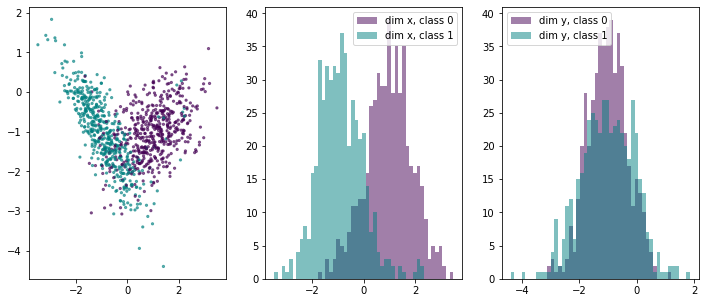

In [33]:
plot_dataset_2D(X[:,(0,1)], y)

In [39]:
X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.2)

In [40]:
X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=0.25*np.pi, biasedClass=0, prob=0)

c:\users\zac\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


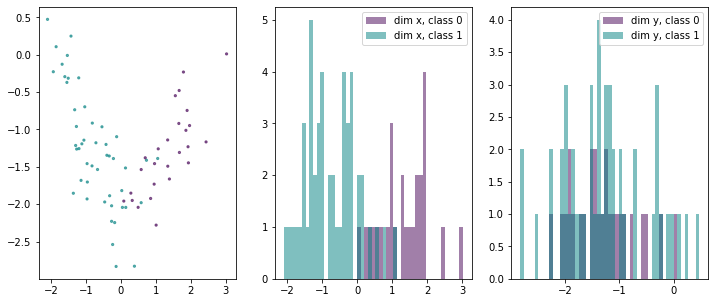

In [41]:
plot_dataset_2D(X_biased[:,(0,1)], y_biased)

In [83]:
query_methods = {
    "random": random_batch,
    "uncertainty": batch.uncertainty_batch_sampling,
    "uncertainty_id": uncertainty_id,
    "fgm": fgm,
    "deepfool": deepfool
}

DeepFool: 100%|██████████████████████████████| 10/10 [00:01<00:00,  6.56it/s]


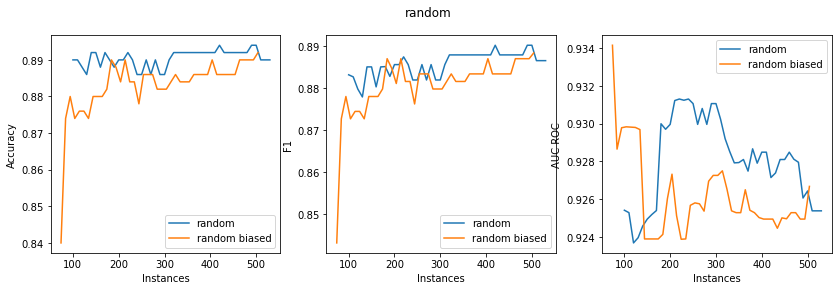

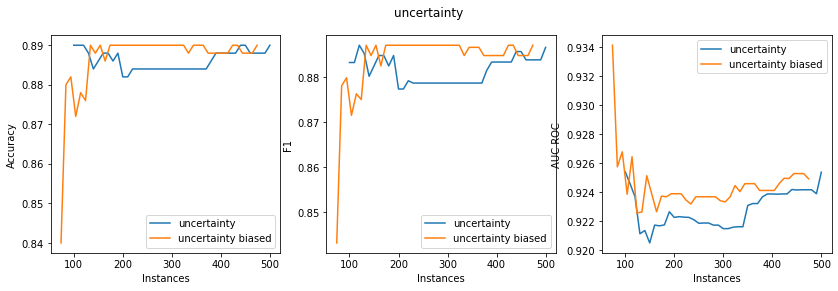

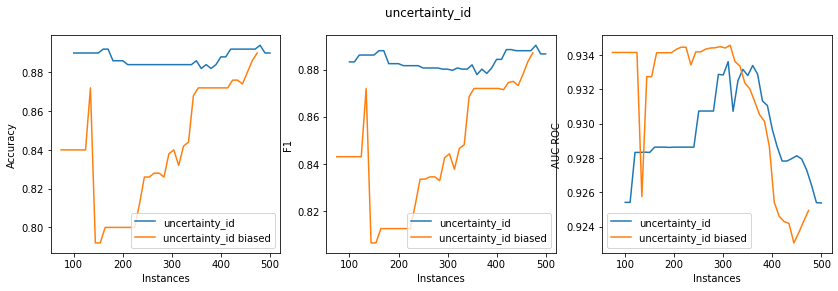

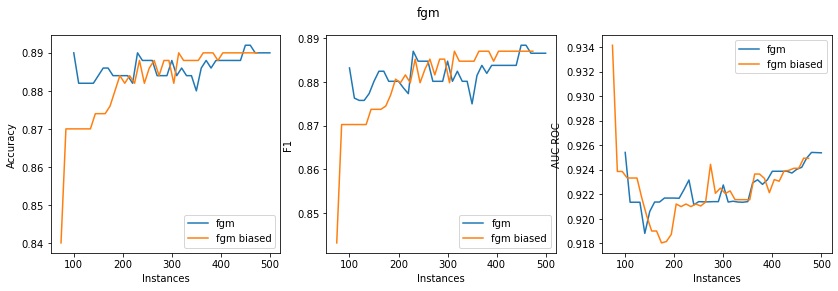

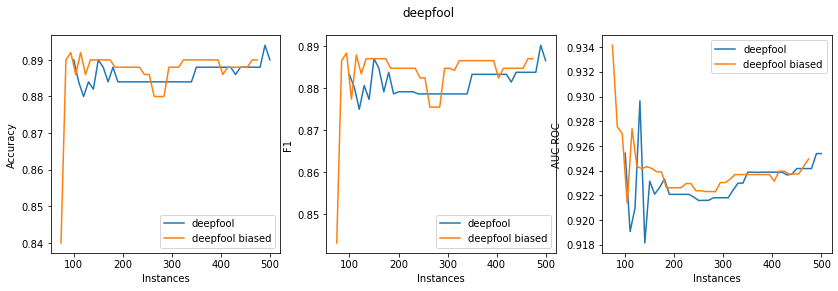

In [84]:
for name, method in query_methods.items():
    results = active_learn(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method, n_instances=10))
    biased_results = active_learn(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
    fig, axes = plt.subplots(1, 3, figsize=(14,4))
    for i, ax in enumerate(axes.flatten()):
        ax.plot(results[0], results[1+i], label=name);
        ax.plot(biased_results[0], biased_results[1+i], label=f"{name} biased")
        ax.legend(); ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); fig.suptitle(name)

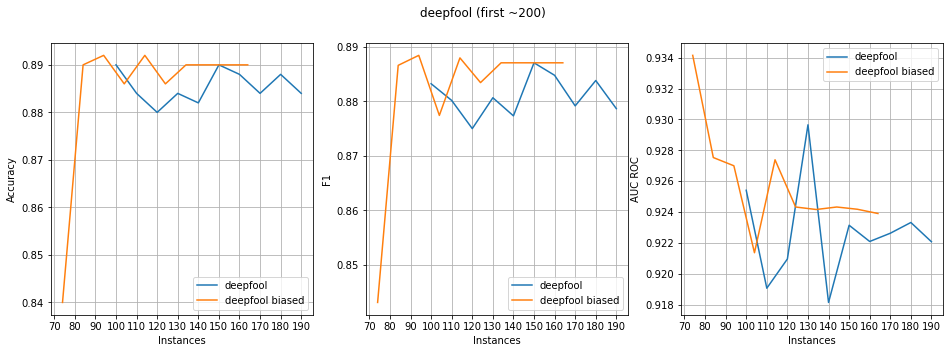

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, ax in enumerate(axes.flatten()):
    ax.plot(results[0][:10], results[1+i][:10], label=name);
    ax.plot(biased_results[0][:10], biased_results[1+i][:10], label=f"{name} biased")
    ax.legend(); ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); fig.suptitle(f"{name} (first ~200)"); ax.grid();
    ax.set_xticks(np.arange(70, 200, 10))

## Experiment 2

* 1000 points
* With Noise
* Bias angle $\frac{\pi}{4}$
* labeled_size $0.3$

In [101]:
X, y = generateData_twoPills_2D(1000)

c:\users\zac\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


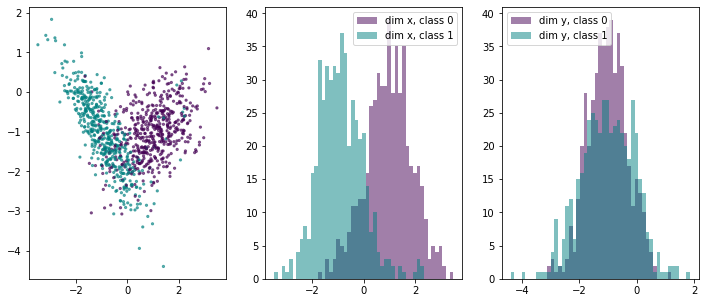

In [102]:
plot_dataset_2D(X[:,(0,1)], y)

In [103]:
X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.3)

In [104]:
X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=0.25*np.pi, biasedClass=0, prob=0)

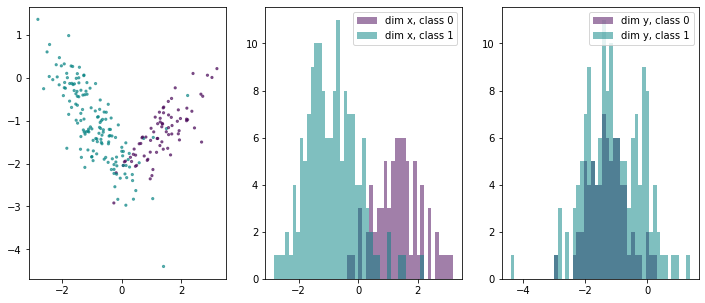

In [105]:
plot_dataset_2D(X_biased[:,(0,1)], y_biased)

In [143]:
query_methods = {
    "random": random_batch,
    "uncertainty": batch.uncertainty_batch_sampling,
    "uncertainty_id": uncertainty_id,
    "fgm": fgm,
    # deepfool is **slow**
    #"deepfool": deepfool
}

Comparison with unbiased.

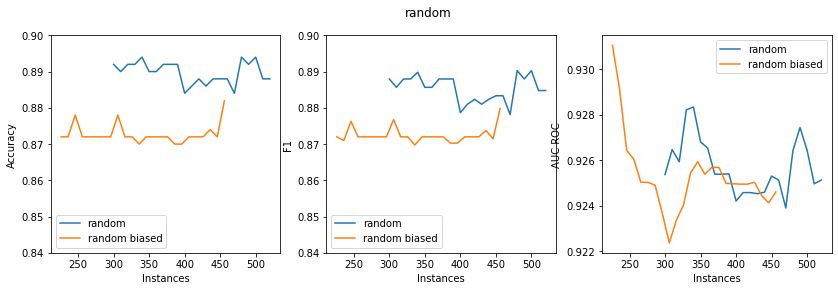

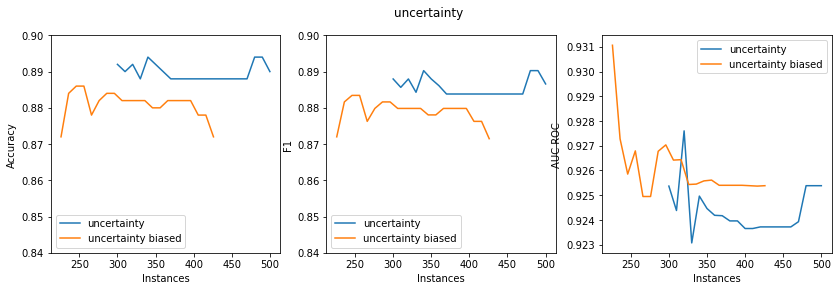

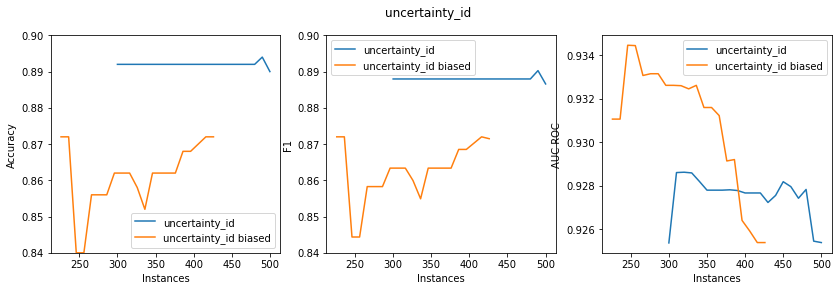

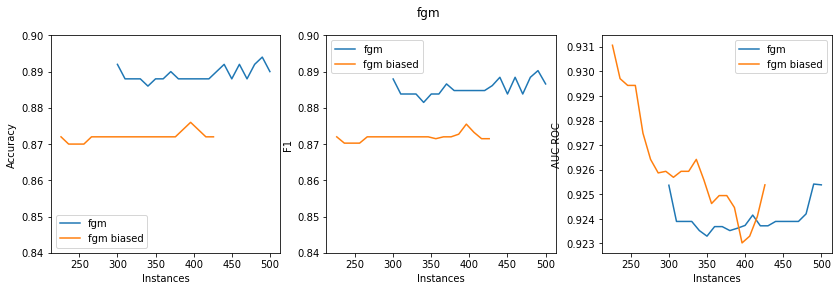

In [110]:
for name, method in query_methods.items():
    results = active_learn(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method, n_instances=10))
    biased_results = active_learn(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
    fig, axes = plt.subplots(1, 3, figsize=(14,4))
    for i, ax in enumerate(axes.flatten()):
        ax.plot(results[0], results[1+i], label=name);
        ax.plot(biased_results[0], biased_results[1+i], label=f"{name} biased")
        ax.legend(); ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); fig.suptitle(name);
        if i != 2:
            ax.set_ylim(0.84, 0.9)

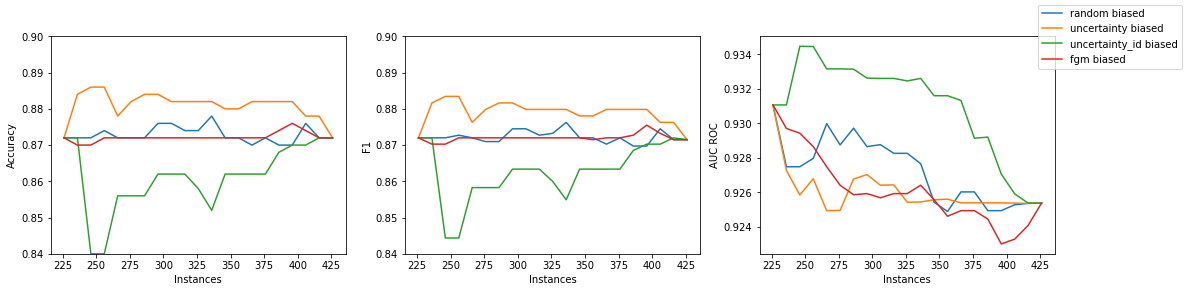

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(18,4))
for name, method in query_methods.items():
    #results = active_learn(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, partial(method, n_instances=10))
    biased_results = active_learn(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
    for i, ax in enumerate(axes.flatten()):
        #ax.plot(results[0], results[1+i], label=name  if i == 0 else "");
        ax.plot(biased_results[0], biased_results[1+i], label=f"{name} biased" if i == 0 else "")
        ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i])
        if i != 2:
            ax.set_ylim(0.84, 0.9)
fig.legend();

Notes: Observing the effect we're looking for is a delicate balance. An initial labeled set that is too small means that the bias doesn't weight the overall data to cause enough of a problem. On the other hand using an initially biased set that is too big means that the active learner doesn't really have to do anything (as the decision boundary is already in an approximately correct position).

Perhaps we should be actively trying to find a pathalogically bad case*, as that's really what we want these active learning algorithms to avoid?

\* As could occur if they repeatedly sampled from a single reigon due to bias...

## Experiment 3

* 1000 points
* With Noise
* Bias angle [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75] pi
* Labelled set size $0.1$
* Batch size $10$

## Main Experiments

Baseline:

* $1000$ points
* Bias angle $\pi$
* Noise
* Labelled set size $0.1$
* Batch size $10$

In [297]:
query_methods = {
    "random": random_batch,
    "uncertainty": batch.uncertainty_batch_sampling,
    "uncertainty_id": uncertainty_id,
    "fgm": fgm,
    # deepfool is **slow**
    "deepfool": deepfool
}

In [284]:
X, y = generateData_twoPills_2D(1000)

In [296]:
df = pd.DataFrame(X)
df.insert(2, 'labels', y)
df.to_csv('Experiments/data.csv')

## Bias Angle

<ipython-input-299-d39388b33174>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


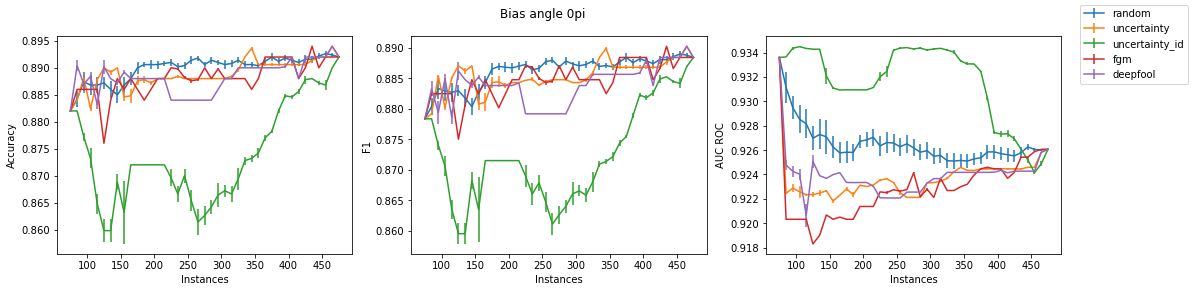

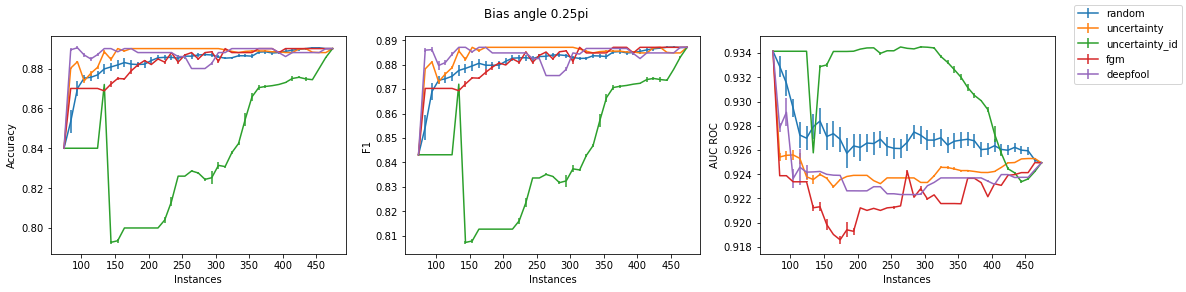

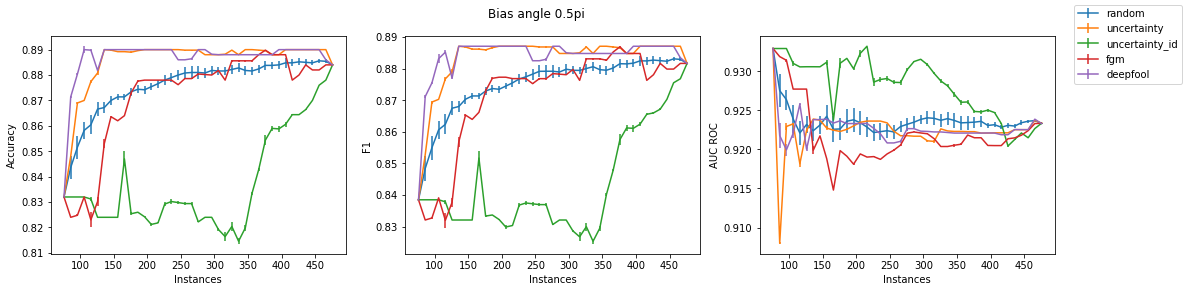

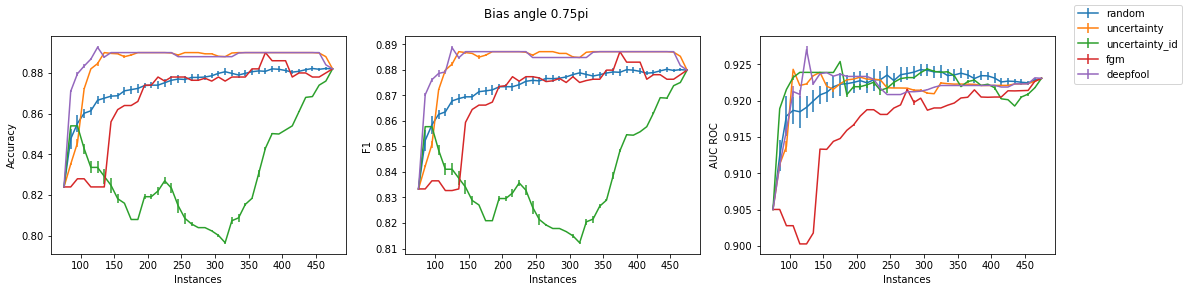

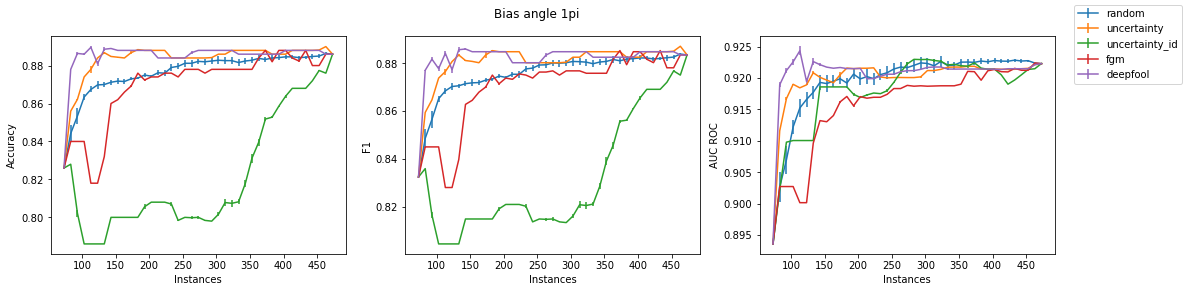

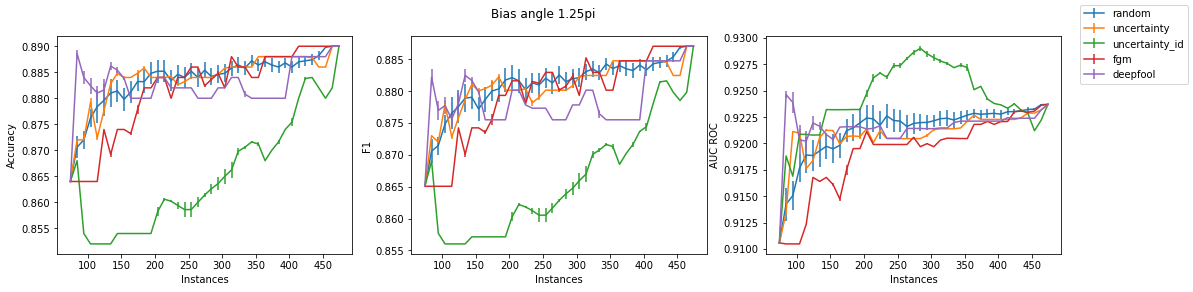

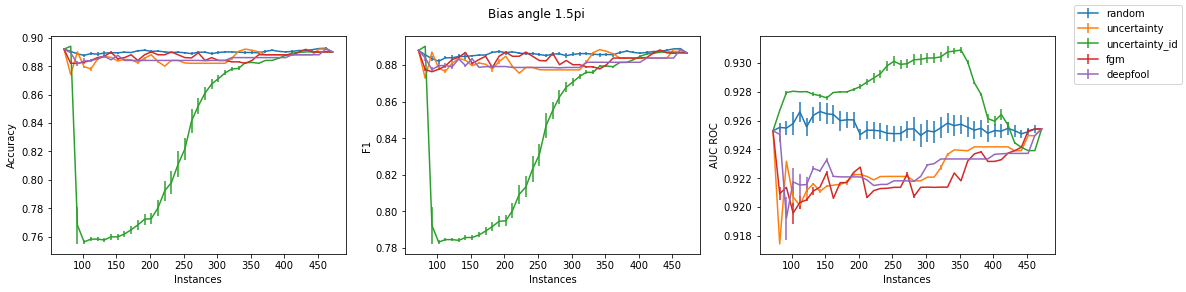

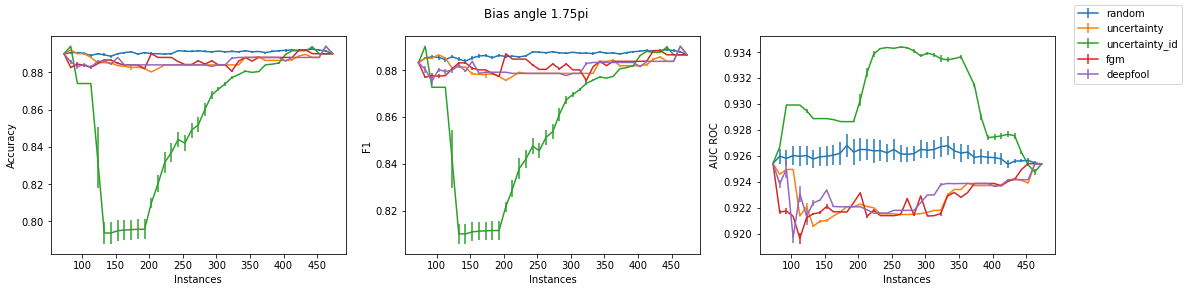

In [299]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)

for angle in tqdm([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75], desc="Angle", leave=False):
    X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=angle*np.pi, biasedClass=0, prob=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
            delayed(
                active_learn2
            )(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
            for _ in range(10)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        metrics.to_csv(f"Experiments/experiment_angle_{angle}_method_{method.__name__}.csv")
        stderr.to_csv(f"Experiments/experiment_angle_{angle}_method_{method.__name__}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"Bias angle {angle}pi")
            #if i != 2:
                #ax.set_ylim(0.84, 0.9)
                
    fig.legend()
    fig.show();

## Labelled set size

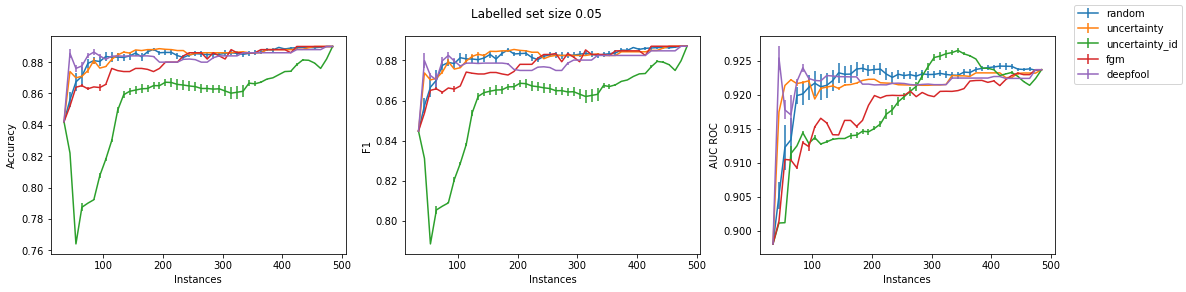

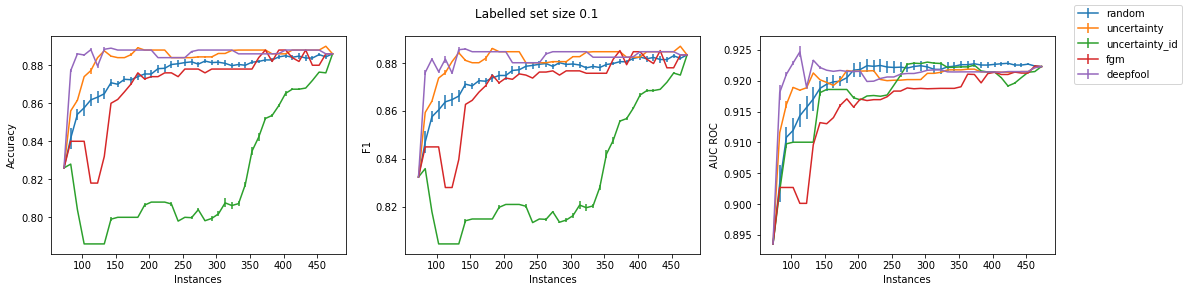

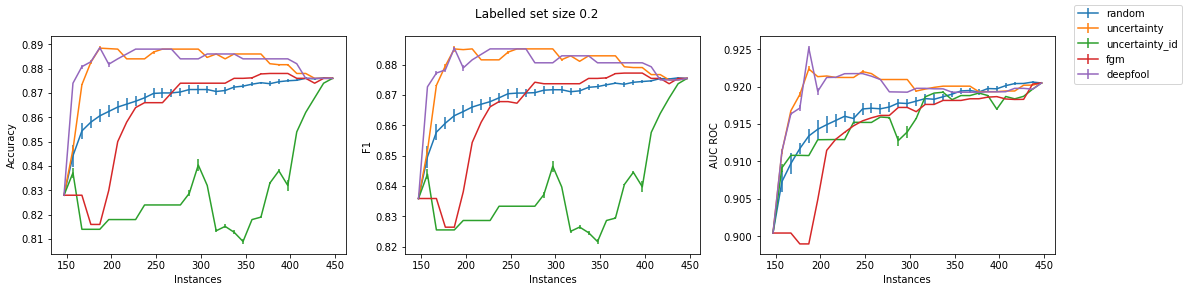

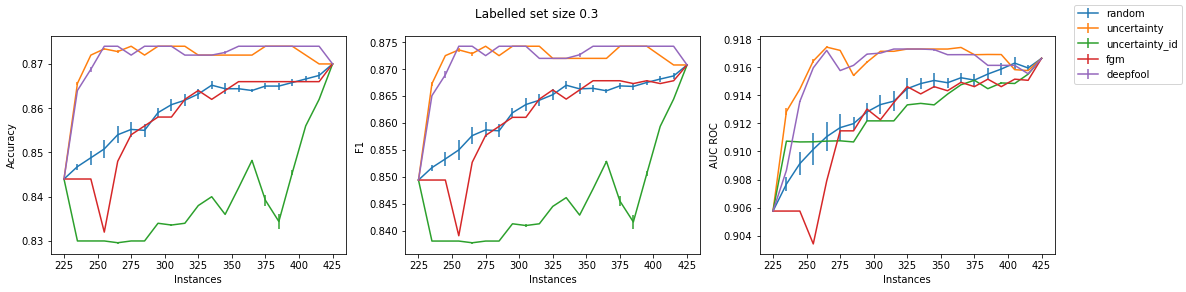

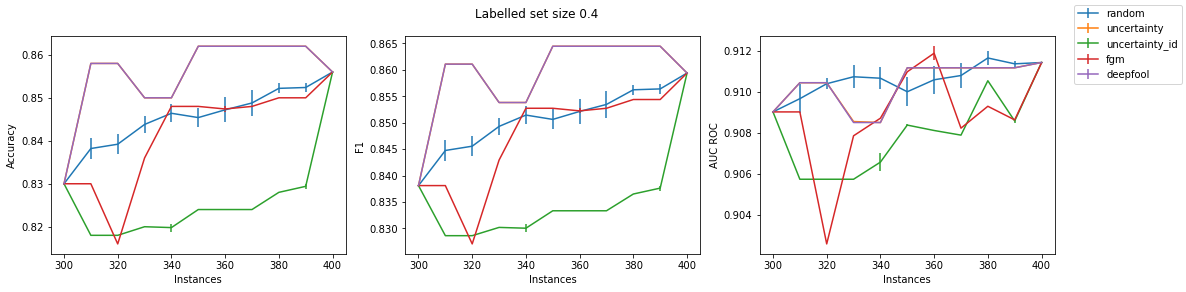

In [300]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

for labelled_size in tqdm([0.05, 0.1, 0.2, 0.3, 0.4], desc="Labelled size", leave=False):
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=labelled_size)
    
    X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=np.pi, biasedClass=0, prob=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
            delayed(
                active_learn2
            )(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=10))
            for _ in range(10)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        metrics.to_csv(f"Experiments/experiment_labelled_{labelled_size}_method_{method.__name__}.csv")
        stderr.to_csv(f"Experiments/experiment_labelled_{labelled_size}_method_{method.__name__}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"Labelled set size {labelled_size}")
            #if i != 2:
                #ax.set_ylim(0.84, 0.9)
                
    fig.legend();

**Notes**

* With a labelled set size of $0.4$ uncertainty_id was exactly as good as deepfool. 

## Batch size

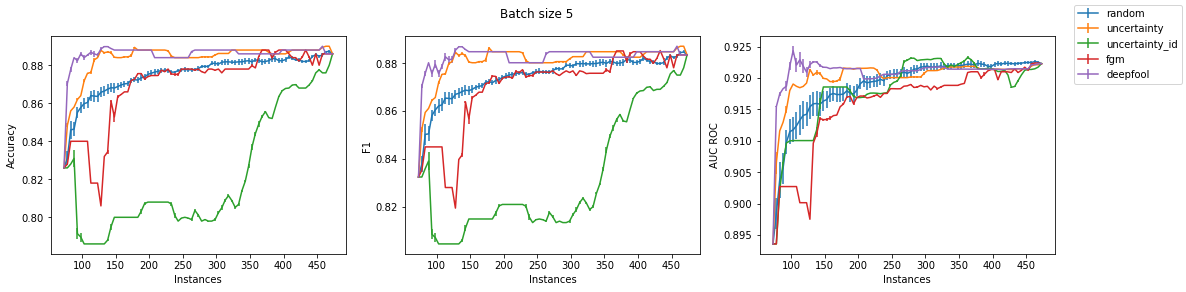

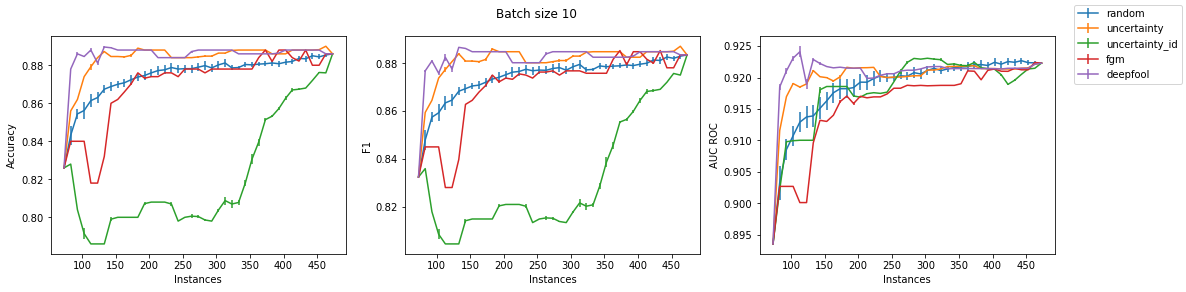

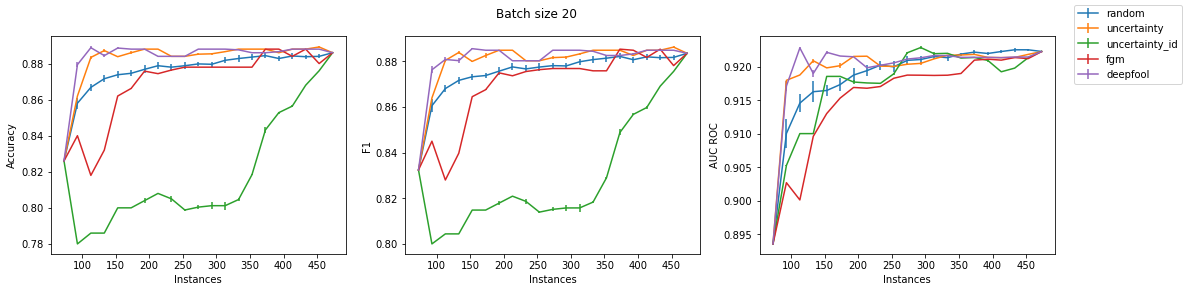

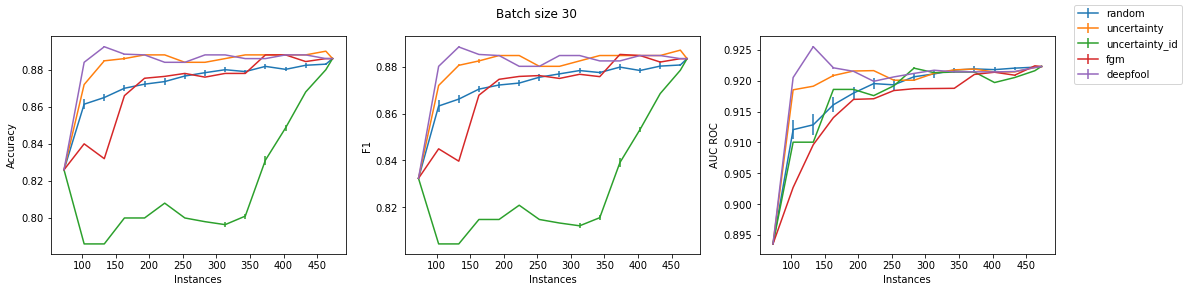

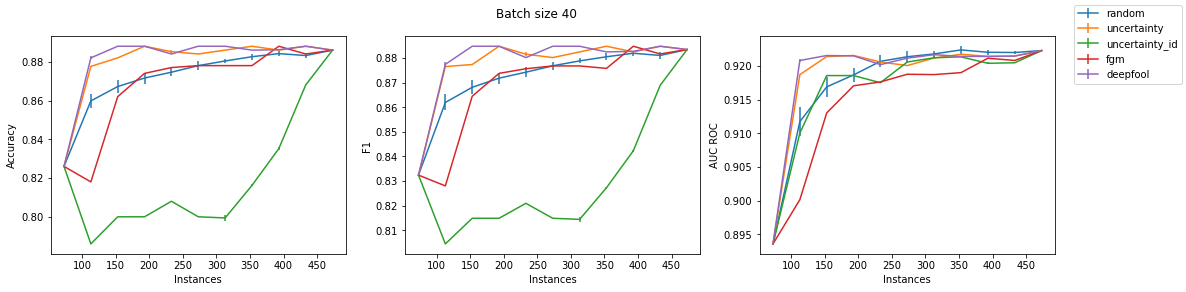

In [301]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

for batch_size in tqdm([5, 10, 20, 30, 40], desc="Batch size", leave=False):
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)
    
    X_biased, y_biased = Bias.bias_rotate_2D(X_labelled, y_labelled, alpha=np.pi, biasedClass=0, prob=0)
    
    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
            delayed(
                active_learn2
            )(X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, partial(method, n_instances=batch_size))
            for _ in range(10)
        )

        metrics, stderr = metrics[0].average(metrics[1:])
        metrics.to_csv(f"Experiments/experiment_batch_{batch_size}_method_{method.__name__}.csv")
        stderr.to_csv(f"Experiments/experiment_batch_{batch_size}_method_{method.__name__}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"Batch size {batch_size}")
            #if i != 2:
                #ax.set_ylim(0.84, 0.9)
                
    fig.legend();